# Analysing the data

Before starting the task, let's analyze the data. Let's start by getting genre list, amount of lines with given genre and average genre rating.

In [36]:
import pandas as pd
import json
import os

# Load the CSV file
file_path = 'data/anime.csv'
columns = ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']
df = pd.read_csv(file_path, usecols=columns)

# Drop rows with missing values in 'genre' or 'rating' to ensure clean analysis
df = df.dropna(subset=['genre', 'rating'])

# Split genres into individual rows
genres_df = df.assign(genre=df['genre'].str.split(',')).explode('genre')

# Remove leading/trailing whitespaces from genre names
genres_df['genre'] = genres_df['genre'].str.strip()

# Group by genre and calculate count and mean rating
genre_stats = genres_df.groupby('genre').agg(
    count=('genre', 'size'),
    avg_rating=('rating', 'mean')
).reset_index()

# Sort by avg_rating
genre_stats = genre_stats.sort_values(by='avg_rating', ascending=False)

# Get a simple list of unique genres
unique_genres = genres_df['genre'].unique()

# Create the data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Write the genre list to a JSON file
json_file_path = 'generated_data/genre_list.json'
with open(json_file_path, 'w') as json_file:
    json.dump(unique_genres.tolist(), json_file, indent=4)

# Print summary information
print(f"Total rows: {len(df)}")
print(f"Total unique genres: {len(unique_genres)}")
print(f"Genre list has been saved to: {json_file_path}")

# Display the genre statistics
print("\nGenre statistics:")
print(genre_stats)


Total rows: 12017
Total unique genres: 43
Genre list has been saved to: generated_data/genre_list.json

Genre statistics:
            genre  count  avg_rating
14          Josei     52    7.443077
39       Thriller     86    7.382326
21        Mystery    485    7.232412
23         Police    195    7.122051
32        Shounen   1684    7.057553
24  Psychological    226    7.010398
19       Military    416    7.004904
38   Supernatural   1001    7.000380
25        Romance   1437    6.999054
31      Shoujo Ai     54    6.978148
6           Drama   1977    6.977218
27         School   1176    6.972049
29         Seinen    532    6.966353
10          Harem    313    6.965687
33     Shounen Ai     62    6.961613
37    Super Power    451    6.906785
40        Vampire    100    6.884600
30         Shoujo    594    6.875976
26        Samurai    146    6.853836
17   Martial Arts    264    6.819356
16          Magic    747    6.805890
0          Action   2768    6.787150
9            Game    177   

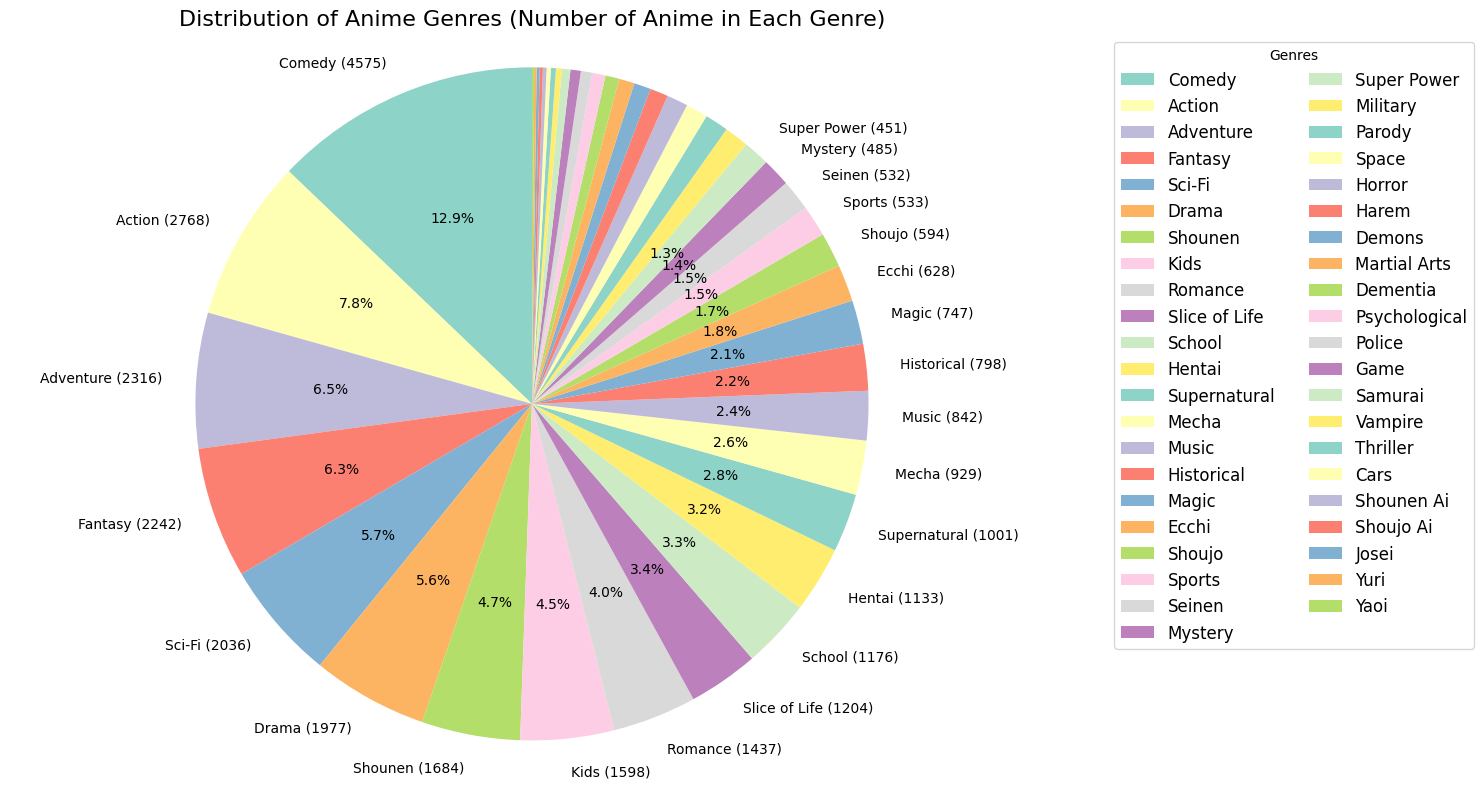

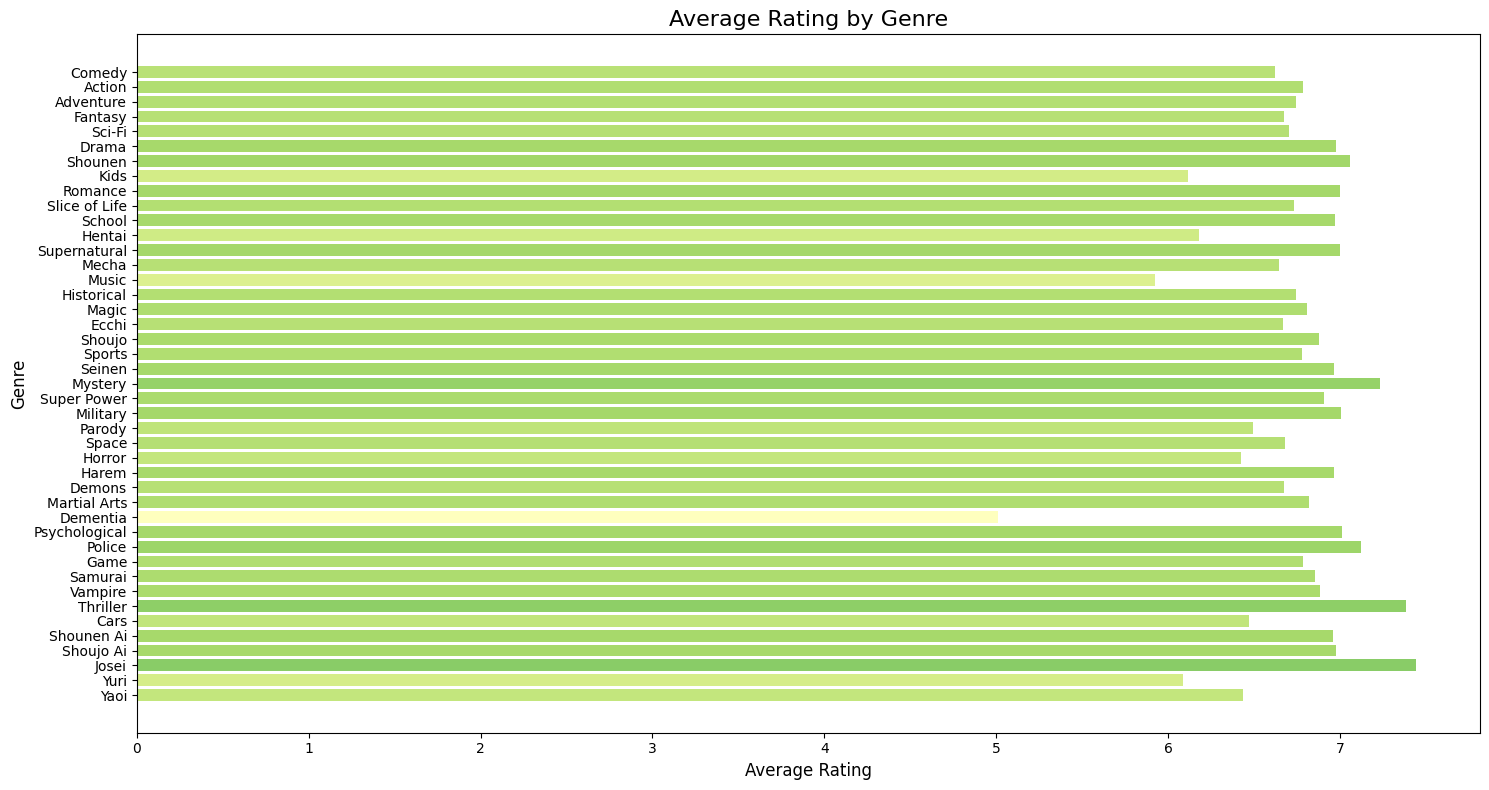

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Sort genres by count (number of anime in each genre) before plotting
genre_stats_sorted = genre_stats.sort_values(by="count", ascending=False)

# Custom function for displaying percentages above 1.2%
def autopct_format(pct):
    return f"{pct:.1f}%" if pct > 1.2 else ""


# 1. Pie chart – Number of Anime in Each Genre
plt.figure(figsize=(15, 8))

labels = [
    f"{genre} ({count})" if count > genre_stats_sorted["count"].quantile(0.475) else ""
    for genre, count in zip(genre_stats_sorted["genre"], genre_stats_sorted["count"])
]

plt.pie(
    genre_stats_sorted["count"],
    labels=labels,
    autopct=autopct_format,
    startangle=90,
    colors=sns.color_palette("Set3", len(genre_stats_sorted)),
)

plt.title("Distribution of Anime Genres (Number of Anime in Each Genre)", fontsize=16)
plt.axis("equal")  # Keeps the pie chart circular
plt.legend(
    genre_stats_sorted["genre"],
    title="Genres",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    ncol=2,
    fontsize=12,
)  # Legend with 2 columns

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# 2. Bar chart – Average Rating by Genre
plt.figure(figsize=(15, 8))

# Define a color palette from red (low) to green (high) based on a rating scale of 0-10
norm = mcolors.Normalize(vmin=0, vmax=10)
cmap = plt.colormaps["RdYlGn"]
colors = [cmap(norm(value)) for value in genre_stats_sorted["avg_rating"]]

# Create the bar chart
barplot = plt.barh(
    genre_stats_sorted["genre"], genre_stats_sorted["avg_rating"], color=colors
)

# Add chart titles and labels
plt.title("Average Rating by Genre", fontsize=16)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)

# Adjust text angle and layout
plt.gca().invert_yaxis()  # Invert y-axis to show highest rating at the top
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

# Read the CSV files into DataFrames
anime_df = pd.read_csv('data/anime.csv')
rating_df = pd.read_csv('data/rating.csv')

# Drop the 'rating' column from anime_df before merge
anime_df = anime_df.drop(columns=['rating'], errors='ignore')

# Merge the two DataFrames on 'anime_id'
merged_df = pd.merge(rating_df, anime_df, on='anime_id', how='inner')

# Filter out rows where the rating is -1
filtered_df = merged_df[merged_df['rating'] != -1]

# Group by 'user_id' and create the desired list for each user, including 'genre'
user_ratings = filtered_df.groupby('user_id').apply(
    lambda x: x[['anime_id', 'name', 'rating', 'genre']].values.tolist()
).reset_index(name='anime_ratings')

# Export the result to a JSON file
user_ratings.to_json('generated_data/user_watched.json', orient='records', lines=True)
print("Data has been exported to generated_data/user_watched.json")


C:\Users\wozni\AppData\Local\Temp\ipykernel_23040\3373882508.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_ratings = filtered_df.groupby('user_id').apply(


Data has been exported to generated_data/user_watched.json


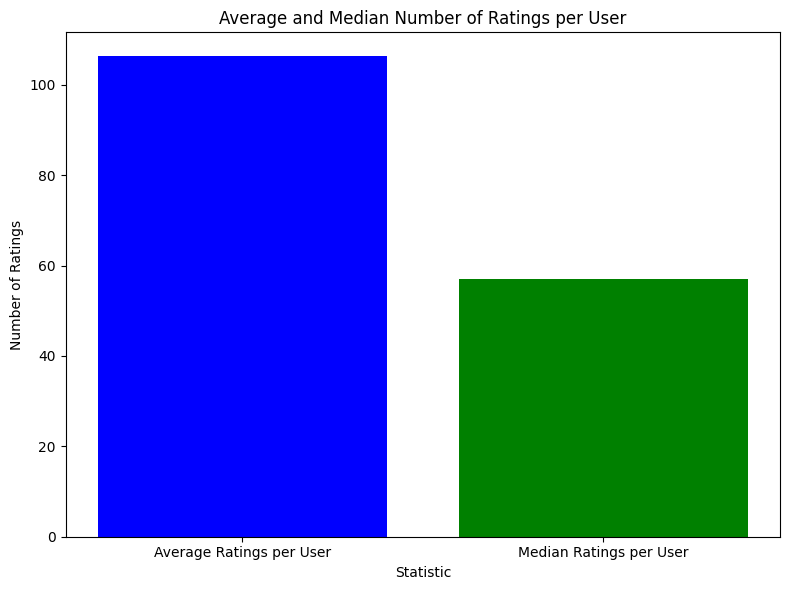

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

anime_df = pd.read_csv('data/anime.csv')
rating_df = pd.read_csv('data/rating.csv')

ratings_per_user = rating_df.groupby('user_id').size()

average_ratings = ratings_per_user.mean()
median_ratings = ratings_per_user.median()

plt.figure(figsize=(8, 6))
plt.bar(['Average Ratings per User', 'Median Ratings per User'], [average_ratings, median_ratings], color=['blue', 'green'])

plt.title('Average and Median Number of Ratings per User')
plt.ylabel('Number of Ratings')
plt.xlabel('Statistic')

plt.tight_layout()
plt.show()
